# 9TSCS/TSCS.py

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
os.chdir('../KocPythonFall2021/inclass/9TSCS/')

In [2]:
data = pd.read_stata('WCRWreplication.dta')

In [3]:
data.head()

,defect,outcome,peakmembership,eyear,byear,location,campaign,target,lccode,tccode,...,lmtnest,ef,loclpolity1,loclcap1,loclcap2,loclcap3,loclcap4,mempc,demdum,recur1
0,1.0,5,50000.0,1959,1956,Cuba,Cuban Revolution,Batista regime,40.0,40.0,...,1.694107,0.2134,-9.0,0.0,1.0,0.0,0.0,1.226839,0.0,0.0
1,0.0,3,5000.0,1920,1918,Haiti,Caco Revolt,U.S. occupation,41.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,1.0,5,30000.0,1985,1985,Haiti,,Jean Claude Duvalier,41.0,41.0,...,2.797281,0.0950,-9.0,1.0,0.0,0.0,0.0,1.200712,0.0,0.0
3,0.0,3,650.0,1924,1916,Dominican Republic,Dominican insurgency,U.S. occupation,42.0,2.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,0.0,NaN
4,1.0,3,NaN,1965,1965,Dominican Republic,leftists,Loyalist regime,42.0,42.0,...,2.856470,0.3868,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0


In [4]:
data.columns

Index(['defect', 'outcome', 'peakmembership', 'eyear', 'byear', 'location',
       'campaign', 'target', 'lccode', 'tccode', 'nonviol', 'viol', 'fselfdet',
       'regchange', 'secession', 'other', 'success', 'limited', 'failure',
       'ongoing', 'middleeast', 'americas', 'asia', 'fsu', 'europe', 'africa',
       'lpolity', 'tpolity', 'lgovcap', 'tgovcap', 'regviol', 'violsim',
       'extfor', 'statesup', 'regaid', 'sdirect', 'deltatpolity', 'deltatgdp',
       'lduration', 'lmembers', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8',
       't9', 't10', 't11', 'cw', 'postcw', 'ixnNVmem', 'rgdppc',
       'growthrgdppc', 'lupop', 'recur5', 'recur10', 'polityt10', 'polityt1',
       'polityt5', 'politychanget10', 'politychanget1', 'politychanget5',
       'politychanget0', 'authdum', 'deltatgovcap', 'memdum', 'lnpop',
       'ixnNVpc', 'lpolity1', 'lcinc1', 'lgdppc', 'wars', 'lmtnest', 'ef',
       'loclpolity1', 'loclcap1', 'loclcap2', 'loclcap3', 'loclcap4', 'mempc',
       'demdum',

- Argument of original analysis is that non-violent as opposed to violent protests are more associated with increases in polity scores (level of democracy)
- What problems may arise in this analysis?
- Side note: does this theoretically make sense?

## TSCS and Panel Data Analyses

- There are no agreed upon defining characteristics between TSCS and panel data, but for our purposes we will refer to large N, mostly balanced data as panel
- It is very important to note which of the modeling strategies (most of them) assume balance; this is often overlooked
- We will first deal with protest data, and the relationship between violent protest and polity change

### One- and Two-Way Fixed Effects Models

- A `fixed effect` is colloquially simply an indicator, a dummy variable - but really they are all effects that are not assumed randomly distributed
- In panel data, we can include a `wave` (temporal) effect and/or a unit effect
- Most common to use two-way (both temporal and unit) for panel data
- For TSCS, two-way is also common, but the interpretability and framework are hurt by multiple observations for a unit-time
- Fixed effects control for heterogeneity in the data
- The inclusion of unit and time fixed effects accounts for both unit-specific (but time-invariant) and time-specific (but unit-invariant) unobserved confounders in a flexible manner
- Additivity and separability of the two types of unobserved confounders
- However, their statistical power can be very low with small N, because of the loss in degrees of freedom
- Unlike random/mixed effects, they do not have distributional assumptions
- These two points mean that there is no information `borrowed` from other unit-times, and the variation that would be explained by your independent variable is largely absorbed
- These have great asymptotic properties, but a lot of research on the actual practice show they perform rather poorly, even when assumptions are met
    - **Linearity** (although one could nonparametrically adjust for unit-specific (time-specific) unobserved confounders by matching a treated observation with control observations of the same unit (time period), no other observation shares the same unit and time indices. Thus, the 2FE estimator critically relies upon the linearity assumption for its simultaneous adjustment for the two types of unobserved confounders)
    - **Separability** (precisely when their respective convex hulls are disjoint (colloquially, do not overlap); means that the marginal rate of substitution between any pair of primary inputs is independent of the amount of intermediate inputs used)
    - **Additivity** (means that the effect of one independent variable(s) on the dependent variable does NOT depend on the value of another independent variable(s))
    - **Functional form assumption** (are we modeling the DGP?)
    - **Adjustment for the two types of unobserved confounders cannot be done nonparametrically under the 2FE framework**
- Very simple to run; just a linear model with factors
- Let us explore the models from temporal, but take into account that this is actually (highly unbalanced) TSCS data

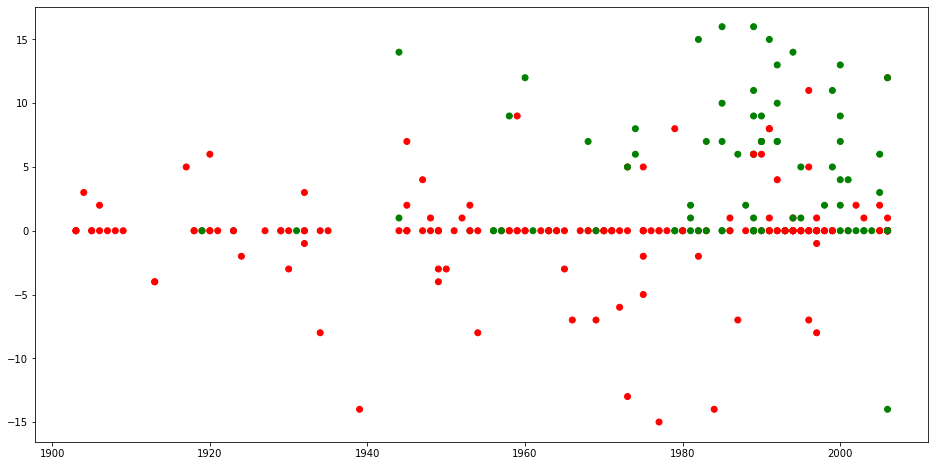

In [5]:
from matplotlib.colors import from_levels_and_colors
plt.figure(figsize=(16, 8))
cmap, _ = from_levels_and_colors([-.5, .5, 1.5], ['red', 'green']) #red for violent, green for nonviolent
plt.scatter(data.eyear, data.politychanget1, c = data.nonviol, cmap = cmap)
plt.show()

- What do we see?
- Looking at the above plot, it seems that non-violent movements are more associated with increases in polity scores - but what can go wrong?

In [6]:
X = pd.DataFrame(data.nonviol)
X['constant'] = 1
simpleMod = sm.OLS(data.politychanget1, X, missing = 'drop').fit()
simpleMod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         politychanget1   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     48.39
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.89e-11
Time:                        15:25:15   Log-Likelihood:                -742.27
No. Observations:                 259   AIC:                             1489.
Df Residuals:                     257   BIC:                             1496.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nonviol        3.8939      0.560      6.956      0.000       2.792       4.996
constant      -0.0643      0.326     -0.197      0.844      -0.707       0.578
==============================================================================
Omnibus:                       21.895   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.682
Skew:                          -0.080   Prob(JB):                     1.11e-18
Kurtosis:                       5.763   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Positive effect (but really?)


- Lets add a temporal effect - the beginning year seems most appropriate

In [7]:
timeMod = smf.ols('politychanget1 ~ nonviol + C(byear)', data = data).fit()
timeMod.summary() #holds up

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         politychanget1   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.213
Date:                Thu, 09 Dec 2021   Prob (F-statistic):              0.143
Time:                        15:25:15   Log-Likelihood:                -701.51
No. Observations:                 259   AIC:                             1581.
Df Residuals:                     170   BIC:                             1898.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4.471e-15      4.482   9.98e-16      1.000      -8.848       8.848
C(byear)[T.1901]  8.555e-15      6.339   1.35e-15      1.000     -12.513      12.513
C(byear)[T.1902]  9.593e-15      6.339   1.51e-15      1.000     -12.513      12.513
C(byear)[T.1903]  1.709e-14      6.339    2.7e-15      1.000     -12.513      12.513
C(byear)[T.1904]     1.5000      5.490      0.273      0.785      -9.337      12.337
C(byear)[T.1905]     2.0000      6.339      0.316      0.753     -10.513      14.513
C(byear)[T.1906]  1.078e-14      6.339    1.7e-15      1.000     -12.513      12.513
C(byear)[T.1907]  2.063e-14      5.490   3.76e-15      1.000     -10.837      10.837
C(byear)[T.1908]  7.686e-15      6.339   1.21e-15      1.000     -12.513      12.513
C(byear)[T.1910]  1.554e-14      6.339   2.45e-15      1.000     -12.513      12.513
C(byear)[T.1911]    -4.0000      6.339     -0.631      0.529     -16.513       8.513
C(byear)[T.1912]    -4.0000      6.339     -0.631      0.529     -16.513       8.513
C(byear)[T.1916]     5.0000      6.339      0.789      0.431      -7.513      17.513
C(byear)[T.1917]  1.242e-14      5.490   2.26e-15      1.000     -10.837      10.837
C(byear)[T.1918]  8.655e-15      5.490   1.58e-15      1.000     -10.837      10.837
C(byear)[T.1919]     0.8096      5.183      0.156      0.876      -9.422      11.041
C(byear)[T.1920]  8.639e-16   2.97e-15      0.290      0.772   -5.01e-15    6.73e-15
C(byear)[T.1921]  5.894e-17   3.41e-15      0.017      0.986   -6.67e-15    6.79e-15
C(byear)[T.1922]    -3.0000      6.339     -0.473      0.637     -15.513       9.513
C(byear)[T.1923]    -1.8570      5.183     -0.358      0.721     -12.088       8.374
C(byear)[T.1924]  2.273e-14      5.490   4.14e-15      1.000     -10.837      10.837
C(byear)[T.1925]  1.986e-14      6.339   3.13e-15      1.000     -12.513      12.513
C(byear)[T.1926]    -3.0000      6.339     -0.473      0.637     -15.513       9.513
C(byear)[T.1929]  2.027e-14      5.490   3.69e-15      1.000     -10.837      10.837
C(byear)[T.1930]  7.326e-15      6.339   1.16e-15      1.000     -12.513      12.513
C(byear)[T.1931]    -3.5711      6.393     -0.559      0.577     -16.191       9.049
C(byear)[T.1932]     0.6667      5.176      0.129      0.898      -9.550      10.883
C(byear)[T.1934]    -4.0000      5.490     -0.729      0.467     -14.837       6.837
C(byear)[T.1936]   -14.0000      6.339     -2.209      0.029     -26.513      -1.487
C(byear)[T.1937]  7.317e-16   3.56e-15      0.206      0.837    -6.3e-15    7.76e-15
C(byear)[T.1938]  8.314e-15   6.49e-15      1.282      0.202   -4.49e-15    2.11e-14
C(byear)[T.1940]     7.0000      6.339      1.104      0.271      -5.513      19.513
C(byear)[T.1941]  8.271e-15      5.490   1.51e-15      1.000     -10.837      10.837
C(byear)[T.1943]     1.

- Now let's add a location fixed effect

In [8]:
twoWayMod = smf.ols('politychanget1 ~ nonviol + C(byear) + C(location)', data = data).fit()
twoWayMod.summary() #holds up, but keep in mind the very strong assumptions, especially when the fixed effects within country are not allowed to vary over time

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         politychanget1   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     1.399
Date:                Thu, 09 Dec 2021   Prob (F-statistic):             0.0670
Time:                        15:25:15   Log-Likelihood:                -536.47
No. Observations:                 259   AIC:                             1475.
Df Residuals:                      58   BIC:                             2190.
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -5.3293      6.602     -0.807      0.423     -18.545       7.886
C(byear)[T.1901]                               8.8743     10.863      0.817      0.417     -12.870      30.618
C(byear)[T.1902]                              -3.8898      8.721     -0.446      0.657     -21.346      13.567
C(byear)[T.1903]                               2.6646      3.875      0.688      0.494      -5.091      10.421
C(byear)[T.1904]                               4.3624      8.575      0.509      0.613     -12.802      21.527
C(byear)[T.1905]                               8.7737      8.293      1.058      0.294      -7.826      25.373
C(byear)[T.1906]                               2.6646      3.875      0.688      0.494      -5.091      10.421
C(byear)[T.1907]                              -2.9518      8.334     -0.354      0.724     -19.634      13.730
C(byear)[T.1908]                               5.9274      8.211      0.722      0.473     -10.509      22.363
C(byear)[T.1910]                               5.1005      8.446      0.604      0.548     -11.807      22.008
C(byear)[T.1911]                               2.1133      7.906      0.267      0.790     -13.712      17.938
C(byear)[T.1912]                              -0.5090      8.678     -0.059      0.953     -17.879      16.861
C(byear)[T.1916]                              11.7737      8.293      1.420      0.161      -4.826      28.373
C(byear)[T.1917]                               6.4435      7.365      0.875      0.385      -8.300      21.187
C(byear)[T.1918]                               8.6606      9.258      0.935      0.353      -9.872      27.193
C(byear)[T.1919]                               3.7516      6.856      0.547      0.586      -9.972      17.476
C(byear)[T.1920]                            5.504e-15   2.11e-14      0.261      0.795   -3.68e-14    4.78e-14
C(byear)[T.1921]                            -6.16e-15   2.76e-14     -0.223      0.824   -6.14e-14    4.91e-14
C(byear)[T.1922]                               3.1133      7.906      0.394      0.695     -12.712      18.938
C(byear)[T.1923]                               3.9074      7.700      0.507      0.614     -11.506      19.320
C(byear)[T.1924]                               5.2362      7.250      0.722      0.473      -9.276      19.748
C(byear)[T.1925]                              -6.6850      8.479     -0.788      0.434     -23.657      10.287
C(byear)[T.1926]                               2.1005      8.446      0.249      0.804     -14.807      19.008
C(byear)[T.1929]                               5.1005      8.446      0.604      0.548     -11.807      22.008
C(byear)[T.1930]                              -0.8812      9.124     -0.097      0.923

- One detail here is that for fixed effect models, the standard errors need to be clustered. So, instead of doing all our estimation by hand (which is only nice for pedagogical reasons), we can use the library linearmodels and set the argument cluster_entity to True

In [9]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("politychanget1 ~ nonviol",
                            data=data.set_index(["location", "byear"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary

C:\Users\melihcanyardi\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,politychanget1,R-squared:,0.2162
Estimator:,PanelOLS,R-squared (Between):,0.3214
No. Observations:,259,R-squared (Within):,0.1626
Date:,"Thu, Dec 09 2021",R-squared (Overall):,0.2162
Time:,15:25:16,Log-likelihood,-742.29
Cov. Estimator:,Clustered,,
,,F-statistic:,71.155
Entities:,117,P-value,0.0000
Avg Obs:,2.2137,Distribution:,"F(1,258)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,52.009


- add FE

In [10]:
mod = PanelOLS.from_formula("politychanget1 ~ nonviol + EntityEffects + TimeEffects",
                            data=data.set_index(["location", "byear"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary

Dep. Variable:,politychanget1,R-squared:,0.1907
Estimator:,PanelOLS,R-squared (Between):,0.3207
No. Observations:,259,R-squared (Within):,0.1625
Date:,"Thu, Dec 09 2021",R-squared (Overall):,0.2016
Time:,15:25:16,Log-likelihood,-536.47
Cov. Estimator:,Clustered,,
,,F-statistic:,12.725
Entities:,117,P-value,0.0008
Avg Obs:,2.2137,Distribution:,"F(1,54)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,4.6740


- Now lets look at a balanced example, which makes more intuitive and mathematical sense
- Bosnian ethnic voting as a function of violence experienced during the war

In [11]:
data2 = pd.read_csv('bosnia.csv')
Log_CasualtyMod = smf.ols('Ethnic_Vote_Share ~ Log_Casualty', data = data2).fit()
Log_CasualtyMod.summary() #notice the lack of reliable effects

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Ethnic_Vote_Share   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5215
Date:                Thu, 09 Dec 2021   Prob (F-statistic):              0.471
Time:                        15:25:16   Log-Likelihood:                -1770.5
No. Observations:                 428   AIC:                             3545.
Df Residuals:                     426   BIC:                             3553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       81.2928      0.842     96.570      0.000      79.638      82.947
Log_Casualty    -0.6111      0.846     -0.722      0.471      -2.274       1.052
==============================================================================
Omnibus:                       67.958   Durbin-Watson:                   0.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.877
Skew:                          -1.053   Prob(JB):                     3.38e-22
Kurtosis:                       4.054   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Lets add a province dummy

In [12]:
Log_CasualtyMod2 = smf.ols('Ethnic_Vote_Share ~ Log_Casualty + C(Municipality)', data = data2).fit()
Log_CasualtyMod2.summary() #notice the lack of reliable effects

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Ethnic_Vote_Share   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     7.084
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           1.37e-42
Time:                        15:25:17   Log-Likelihood:                -1512.7
No. Observations:                 428   AIC:                             3239.
Df Residuals:                     321   BIC:                             3674.
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               87.3033      4.578     19.071      0.000      78.297      96.310
C(Municipality)[T.Banovici]                            -17.2237      6.423     -2.681      0.008     -29.861      -4.587
C(Municipality)[T.Bihac]                               -25.1589      5.424     -4.638      0.000     -35.830     -14.488
C(Municipality)[T.Bijeljina]                             1.8110      6.501      0.279      0.781     -10.978      14.600
C(Municipality)[T.Bileca]                                4.6258      7.100      0.652      0.515      -9.342      18.594
C(Municipality)[T.Bosanska Dubica (Kozarska Dubica)]     3.2616      6.360      0.513      0.608      -9.252      15.775
C(Municipality)[T.Bosanska Gradiska (Gradiska)]          5.1892      6.612      0.785      0.433      -7.819      18.197
C(Municipality)[T.Bosanska Krupa]                       -6.9988      5.399     -1.296      0.196     -17.621       3.624
C(Municipality)[T.Bosanski Brod]                        -1.9105      5.694     -0.336      0.737     -13.113       9.292
C(Municipality)[T.Bosanski Novi (Novi Grad)]             6.8438      5.872      1.165      0.245      -4.709      18.397
C(Municipality)[T.Bosanski Petrovac]                   -12.5592      5.324     -2.359      0.019     -23.033      -2.085
C(Municipality)[T.Bosansko Grahovo (Grahovo)]          -12.8228      5.472     -2.344      0.020     -23.588      -2.058
C(Municipality)[T.Bratunac]                             15.8652      4.843      3.276      0.001       6.336      25.394
C(Municipality)[T.Brcko]                               -10.3635      5.625     -1.842      0.066     -21.430       0.703
C(Municipality)[T.Breza]                               -19.3057      5.903     -3.271      0.001     -30.918      -7.693
C(Municipality)[T.Bugojno]                             -16.0337      5.780     -2.774      0.006     -27.405      -4.663
C(Municipality)[T.Busovaca]                             -3.9889      5.587     -0.714      0.476     -14.980       7.002
C(Municipality)[T.Cajnice]                              13.8845      5.054      2.747      0.006       3.941      23.828
C(Municipality)[T.Capljina]                              1.3168      6.936      0.190      0.850     -12.330      14.963
C(Municipality)[T.Cazin]                               -10.9350      5.995     -1.824      0.069     -22.730       0.860
C(Municipality)[T.Celinac]                               6.6039      6.213      1.063      0.289      -5.619      18.827
C(Municipality)[T.Centar Sarajevo]                     -34.0642      5.563     -6.123      0.000     -45.009     -23.119
C(Municipality)[T.Citluk]                                4

- add temporal effects

In [13]:
Log_CasualtyMod3 = smf.ols('Ethnic_Vote_Share ~ Log_Casualty + C(Municipality) + C(Year)', data = data2).fit()
Log_CasualtyMod3.summary() #notice the lack of reliable effects

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Ethnic_Vote_Share   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     7.375
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           1.36e-44
Time:                        15:25:17   Log-Likelihood:                -1501.0
No. Observations:                 428   AIC:                             3222.
Df Residuals:                     318   BIC:                             3668.
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               85.6553      4.543     18.855      0.000      76.717      94.593
C(Municipality)[T.Banovici]                            -17.2240      6.278     -2.743      0.006     -29.576      -4.871
C(Municipality)[T.Bihac]                               -25.1599      5.302     -4.745      0.000     -35.591     -14.729
C(Municipality)[T.Bijeljina]                             1.8109      6.354      0.285      0.776     -10.690      14.312
C(Municipality)[T.Bileca]                                4.6260      6.940      0.667      0.506      -9.028      18.280
C(Municipality)[T.Bosanska Dubica (Kozarska Dubica)]     3.2614      6.217      0.525      0.600      -8.970      15.493
C(Municipality)[T.Bosanska Gradiska (Gradiska)]          5.1891      6.463      0.803      0.423      -7.526      17.905
C(Municipality)[T.Bosanska Krupa]                       -6.9998      5.278     -1.326      0.186     -17.383       3.383
C(Municipality)[T.Bosanski Brod]                        -1.9113      5.566     -0.343      0.732     -12.861       9.039
C(Municipality)[T.Bosanski Novi (Novi Grad)]             6.8432      5.740      1.192      0.234      -4.450      18.136
C(Municipality)[T.Bosanski Petrovac]                   -12.5604      5.204     -2.414      0.016     -22.798      -2.322
C(Municipality)[T.Bosansko Grahovo (Grahovo)]          -12.8238      5.348     -2.398      0.017     -23.346      -2.301
C(Municipality)[T.Bratunac]                             15.8624      4.734      3.351      0.001       6.548      25.177
C(Municipality)[T.Brcko]                               -10.3643      5.498     -1.885      0.060     -21.182       0.453
C(Municipality)[T.Breza]                               -19.3063      5.770     -3.346      0.001     -30.658      -7.955
C(Municipality)[T.Bugojno]                             -16.0345      5.649     -2.838      0.005     -27.150      -4.919
C(Municipality)[T.Busovaca]                             -3.9898      5.461     -0.731      0.466     -14.733       6.754
C(Municipality)[T.Cajnice]                              13.8831      4.940      2.810      0.005       4.163      23.603
C(Municipality)[T.Capljina]                              1.3169      6.780      0.194      0.846     -12.023      14.657
C(Municipality)[T.Cazin]                               -10.9356      5.860     -1.866      0.063     -22.465       0.594
C(Municipality)[T.Celinac]                               6.6035      6.073      1.087      0.278      -5.345      18.552
C(Municipality)[T.Centar Sarajevo]                     -34.0651      5.438     -6.265      0.000     -44.764     -23.367
C(Municipality)[T.Citluk]                                4

In [14]:
Log_CasualtyMod.params['Log_Casualty']

-0.6110990360651349

In [15]:
Log_CasualtyMod2.params['Log_Casualty']

-3.972357751055613

In [16]:
Log_CasualtyMod3.params['Log_Casualty']

-3.9711738960514436

- The coefficient gets larger, even though there are very few degrees of freedom - why?
- We are no longer strictly controlling for heterogeneity, but exploring/exploiting province-year-level variation

### Cluster

In [17]:
mod = PanelOLS.from_formula("Ethnic_Vote_Share ~ Log_Casualty + EntityEffects + TimeEffects", data=data2.set_index(["Municipality", "Year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary #errors, why?

AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          Log_Casualty

Set drop_absorbed=True to automatically drop absorbed variables.


- Log_Casualty is constant within Municipalities, but Ethnic_Vote_Share is not - this module should be able to estimate this model, but it cannot
- instead:

In [18]:
Log_CasualtyMod4 = smf.ols('Ethnic_Vote_Share ~ Log_Casualty + C(Municipality) + C(Year)', data = data2).fit(cov_type = 'cluster', cov_kwds = {'groups': data2.Municipality})
Log_CasualtyMod4.summary() #now we have effects - clustered ses DO NOT ALWAYS WIDEN CIs!

C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 3
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Ethnic_Vote_Share   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     10.37
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           4.82e-06
Time:                        15:25:35   Log-Likelihood:                -1501.0
No. Observations:                 428   AIC:                             3222.
Df Residuals:                     318   BIC:                             3668.
Df Model:                         109                                         
Covariance Type:              cluster                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               85.6553      1.207     70.957      0.000      83.289      88.021
C(Municipality)[T.Banovici]                            -17.2240      0.000  -9.89e+04      0.000     -17.224     -17.224
C(Municipality)[T.Bihac]                               -25.1599      0.001  -3.31e+04      0.000     -25.161     -25.158
C(Municipality)[T.Bijeljina]                             1.8109      0.000   1.34e+04      0.000       1.811       1.811
C(Municipality)[T.Bileca]                                4.6260      0.000   2.95e+04      0.000       4.626       4.626
C(Municipality)[T.Bosanska Dubica (Kozarska Dubica)]     3.2614      0.000   1.58e+04      0.000       3.261       3.262
C(Municipality)[T.Bosanska Gradiska (Gradiska)]          5.1891   7.86e-05    6.6e+04      0.000       5.189       5.189
C(Municipality)[T.Bosanska Krupa]                       -6.9998      0.001  -8987.277      0.000      -7.001      -6.998
C(Municipality)[T.Bosanski Brod]                        -1.9113      0.001  -3278.859      0.000      -1.912      -1.910
C(Municipality)[T.Bosanski Novi (Novi Grad)]             6.8432      0.000   1.44e+04      0.000       6.842       6.844
C(Municipality)[T.Bosanski Petrovac]                   -12.5604      0.001  -1.51e+04      0.000     -12.562     -12.559
C(Municipality)[T.Bosansko Grahovo (Grahovo)]          -12.8238      0.001  -1.76e+04      0.000     -12.825     -12.822
C(Municipality)[T.Bratunac]                             15.8624      0.002   7561.953      0.000      15.858      15.866
C(Municipality)[T.Brcko]                               -10.3643      0.001  -1.65e+04      0.000     -10.366     -10.363
C(Municipality)[T.Breza]                               -19.3063      0.000  -4.22e+04      0.000     -19.307     -19.305
C(Municipality)[T.Bugojno]                             -16.0345      0.001  -3.02e+04      0.000     -16.036     -16.033
C(Municipality)[T.Busovaca]                             -3.9898      0.001  -6126.183      0.000      -3.991      -3.989
C(Municipality)[T.Cajnice]                              13.8831      0.001   1.31e+04      0.000      13.881      13.885
C(Municipality)[T.Capljina]                              1.3169   7.95e-05   1.66e+04      0.000       1.317       1.317
C(Municipality)[T.Cazin]                               -10.9356      0.000   -2.7e+04      0.000     -10.936     -10.935
C(Municipality)[T.Celinac]                               6.6035      0.000   2.32e+04      0.000       6.603       6.604
C(Municipality)[T.Centar Sarajevo]                     -34.0651      0.001  -5.11e+04      0.000     -34.066     -34.064
C(Municipality)[T.Citluk]                                4

- This model is strange (one year is pre-treatment)
- This is an appropriate dataset for introducing the Difference-in-Difference (DiD) estimator
    - DiD estimators have traditionally been used to analyze the effect of a treatment at different times
    - There is absolutely no reason not to use them for continuous treatments though
    - Basically, we interact temporal fixed effects (but not the first, or baseline year) with the variable of interest (and include the constituent terms of time), and include unit fixed effects
    - This is an ideal model for the above Bosnian data
    - However, we need to assume parallel trends, i.e. the units (municipalities) have parallel trends in the outcome if it were not for treatment

- Create a dummy for 2006, 2010, and 2014

In [19]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer_output = label_binarizer.fit_transform(data2.Year)[:,1:] #we do not want 1990 in our dummy
Log_CasualtyModDiD = smf.ols('Ethnic_Vote_Share ~ Log_Casualty*label_binarizer_output + C(Municipality)', data = data2).fit(cov_type = 'cluster', cov_kwds = {'groups': data2.Municipality, 'time': data2.Year})
Log_CasualtyModDiD.summary() #we care about the interaction effects

C:\Users\melihcanyardi\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 113, but rank is 6
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Ethnic_Vote_Share   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     7.353
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           1.37e-06
Time:                        15:25:35   Log-Likelihood:                -1497.0
No. Observations:                 428   AIC:                             3220.
Df Residuals:                     315   BIC:                             3679.
Df Model:                         112                                         
Covariance Type:              cluster                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               86.3405      1.242     69.490      0.000      83.905      88.776
C(Municipality)[T.Banovici]                            -17.2263      0.001  -1.22e+04      0.000     -17.229     -17.224
C(Municipality)[T.Bihac]                               -25.1701      0.006  -4073.042      0.000     -25.182     -25.158
C(Municipality)[T.Bijeljina]                             1.8091      0.001   1654.462      0.000       1.807       1.811
C(Municipality)[T.Bileca]                                4.6281      0.001   3640.138      0.000       4.626       4.631
C(Municipality)[T.Bosanska Dubica (Kozarska Dubica)]     3.2586      0.002   1941.042      0.000       3.255       3.262
C(Municipality)[T.Bosanska Gradiska (Gradiska)]          5.1880      0.001   8127.847      0.000       5.187       5.189
C(Municipality)[T.Bosanska Krupa]                       -7.0102      0.006  -1108.608      0.000      -7.023      -6.998
C(Municipality)[T.Bosanski Brod]                        -1.9191      0.005   -405.501      0.000      -1.928      -1.910
C(Municipality)[T.Bosanski Novi (Novi Grad)]             6.8368      0.004   1771.688      0.000       6.829       6.844
C(Municipality)[T.Bosanski Petrovac]                   -12.5715      0.007  -1856.206      0.000     -12.585     -12.558
C(Municipality)[T.Bosansko Grahovo (Grahovo)]          -12.8335      0.006  -2171.161      0.000     -12.845     -12.822
C(Municipality)[T.Bratunac]                             15.8344      0.017    929.763      0.000      15.801      15.868
C(Municipality)[T.Brcko]                               -10.3727      0.005  -2039.224      0.000     -10.383     -10.363
C(Municipality)[T.Breza]                               -19.3124      0.004  -5197.854      0.000     -19.320     -19.305
C(Municipality)[T.Bugojno]                             -16.0415      0.004  -3725.718      0.000     -16.050     -16.033
C(Municipality)[T.Busovaca]                             -3.9985      0.005   -756.207      0.000      -4.009      -3.988
C(Municipality)[T.Cajnice]                              13.8689      0.009   1610.097      0.000      13.852      13.886
C(Municipality)[T.Capljina]                              1.3179      0.001   2042.261      0.000       1.317       1.319
C(Municipality)[T.Cazin]                               -10.9410      0.003  -3330.679      0.000     -10.947     -10.935
C(Municipality)[T.Celinac]                               6.5997      0.002   2855.814      0.000       6.595       6.604
C(Municipality)[T.Centar Sarajevo]                     -34.0740      0.005  -6296.233      0.000     -34.085     -34.063
C(Municipality)[T.Citluk]                                4

- What happens if we do not use clustered ses?

In [20]:
Log_CasualtyModDiD = smf.ols('Ethnic_Vote_Share ~ Log_Casualty*label_binarizer_output + C(Municipality)', data = data2).fit()
Log_CasualtyModDiD.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Ethnic_Vote_Share   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     7.296
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.16e-44
Time:                        15:25:35   Log-Likelihood:                -1497.0
No. Observations:                 428   AIC:                             3220.
Df Residuals:                     315   BIC:                             3679.
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               86.3405      4.543     19.003      0.000      77.401      95.280
C(Municipality)[T.Banovici]                            -17.2263      6.250     -2.756      0.006     -29.523      -4.930
C(Municipality)[T.Bihac]                               -25.1701      5.278     -4.769      0.000     -35.554     -14.786
C(Municipality)[T.Bijeljina]                             1.8091      6.325      0.286      0.775     -10.636      14.254
C(Municipality)[T.Bileca]                                4.6281      6.908      0.670      0.503      -8.964      18.220
C(Municipality)[T.Bosanska Dubica (Kozarska Dubica)]     3.2586      6.189      0.527      0.599      -8.918      15.435
C(Municipality)[T.Bosanska Gradiska (Gradiska)]          5.1880      6.434      0.806      0.421      -7.470      17.846
C(Municipality)[T.Bosanska Krupa]                       -7.0102      5.254     -1.334      0.183     -17.347       3.326
C(Municipality)[T.Bosanski Brod]                        -1.9191      5.540     -0.346      0.729     -12.820       8.982
C(Municipality)[T.Bosanski Novi (Novi Grad)]             6.8368      5.714      1.197      0.232      -4.405      18.079
C(Municipality)[T.Bosanski Petrovac]                   -12.5715      5.180     -2.427      0.016     -22.763      -2.380
C(Municipality)[T.Bosansko Grahovo (Grahovo)]          -12.8335      5.324     -2.411      0.017     -23.309      -2.358
C(Municipality)[T.Bratunac]                             15.8344      4.713      3.360      0.001       6.562      25.107
C(Municipality)[T.Brcko]                               -10.3727      5.473     -1.895      0.059     -21.141       0.396
C(Municipality)[T.Breza]                               -19.3124      5.743     -3.363      0.001     -30.612      -8.012
C(Municipality)[T.Bugojno]                             -16.0415      5.624     -2.852      0.005     -27.106      -4.977
C(Municipality)[T.Busovaca]                             -3.9985      5.436     -0.736      0.463     -14.693       6.696
C(Municipality)[T.Cajnice]                              13.8689      4.918      2.820      0.005       4.193      23.545
C(Municipality)[T.Capljina]                              1.3179      6.749      0.195      0.845     -11.961      14.597
C(Municipality)[T.Cazin]                               -10.9410      5.833     -1.876      0.062     -22.418       0.536
C(Municipality)[T.Celinac]                               6.5997      6.045      1.092      0.276      -5.295      18.494
C(Municipality)[T.Centar Sarajevo]                     -34.0740      5.413     -6.295      0.000     -44.724     -23.424
C(Municipality)[T.Citluk]                                4

- What if we use robust standard errors (NEVER DO THIS!... unless a reviewer asks)

In [21]:
Log_CasualtyModDiD = smf.ols('Ethnic_Vote_Share ~ Log_Casualty*label_binarizer_output + C(Municipality)', data = data2).fit()
Log_CasualtyModDiD.get_robustcov_results(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Ethnic_Vote_Share   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     1985.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:25:35   Log-Likelihood:                -1497.0
No. Observations:                 428   AIC:                             3220.
Df Residuals:                     315   BIC:                             3679.
Df Model:                         112                                         
Covariance Type:                  HC1                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               86.3405      6.451     13.384      0.000      73.648      99.033
C(Municipality)[T.Banovici]                            -17.2263      7.693     -2.239      0.026     -32.362      -2.091
C(Municipality)[T.Bihac]                               -25.1701      7.389     -3.407      0.001     -39.707     -10.633
C(Municipality)[T.Bijeljina]                             1.8091      7.348      0.246      0.806     -12.647      16.265
C(Municipality)[T.Bileca]                                4.6281      7.912      0.585      0.559     -10.940      20.196
C(Municipality)[T.Bosanska Dubica (Kozarska Dubica)]     3.2586      7.246      0.450      0.653     -10.998      17.515
C(Municipality)[T.Bosanska Gradiska (Gradiska)]          5.1880      6.605      0.785      0.433      -7.808      18.184
C(Municipality)[T.Bosanska Krupa]                       -7.0102      6.261     -1.120      0.264     -19.329       5.308
C(Municipality)[T.Bosanski Brod]                        -1.9191      7.101     -0.270      0.787     -15.891      12.053
C(Municipality)[T.Bosanski Novi (Novi Grad)]             6.8368      5.005      1.366      0.173      -3.011      16.685
C(Municipality)[T.Bosanski Petrovac]                   -12.5715      8.560     -1.469      0.143     -29.414       4.271
C(Municipality)[T.Bosansko Grahovo (Grahovo)]          -12.8335     16.265     -0.789      0.431     -44.836      19.169
C(Municipality)[T.Bratunac]                             15.8344      2.191      7.228      0.000      11.524      20.145
C(Municipality)[T.Brcko]                               -10.3727      4.809     -2.157      0.032     -19.834      -0.912
C(Municipality)[T.Breza]                               -19.3124      5.226     -3.695      0.000     -29.595      -9.030
C(Municipality)[T.Bugojno]                             -16.0415      7.345     -2.184      0.030     -30.493      -1.591
C(Municipality)[T.Busovaca]                             -3.9985      4.166     -0.960      0.338     -12.195       4.198
C(Municipality)[T.Cajnice]                              13.8689      2.834      4.894      0.000       8.293      19.444
C(Municipality)[T.Capljina]                              1.3179      6.970      0.189      0.850     -12.395      15.031
C(Municipality)[T.Cazin]                               -10.9410      8.710     -1.256      0.210     -28.077       6.195
C(Municipality)[T.Celinac]                               6.5997      5.966      1.106      0.269      -5.138      18.338
C(Municipality)[T.Centar Sarajevo]                     -34.0740      4.573     -7.452      0.000     -43.071     -25.077
C(Municipality)[T.Citluk]                                4

- The results are MORE significant

### Visualizing fixed effects

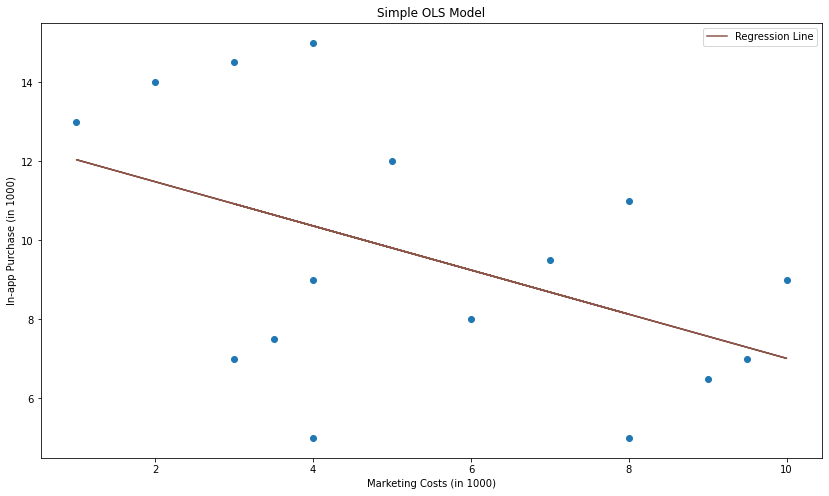

In [22]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.figure(figsize=(14, 8))
plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend()
plt.show()

In [23]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

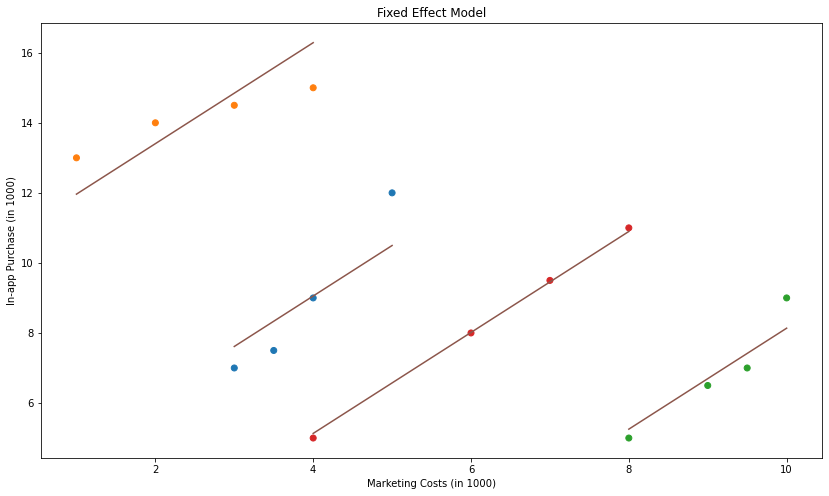

In [24]:
plt.figure(figsize=(14, 8))
plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.show()

## Mixed (Random and Fixed) Effects

- We can use these in much the same way (and a lot more) as FEs
- Random effects have a distributional assumption
- This distribution buys us a lot of things
    - We can borrow information from other units to find a generalized pattern across units
    - The statistical power is much higher
    - The power means we can get false positives, but generally only under mis-specification
    - We can directly estimate the variation of the underlying distribution, meaning we can inspect which levels need variation accounted for
    - We no longer make the assumption of separability, and estimate the covariation of the parameters
- The distribution, in general, assumes that the population under study is representative of the group-of-interest, in that the effects are random realizations of the randomly distributed population (and temporal) heterogeneity (prevalancy kind of)
- We will generally want to go Bayesian, for a number of reasons we will cover later, but basically it allows for much more control over the model and a much more flexible DGP
- Random effects do not require balance
- You can model units that only have one observation
- You can model a small number of units
- You can model a small number of observations
- You can add predictors to the random effects for more precision (contextual effects)
- You can also model any slope coefficient randomly, allowing it to vary at any desired level
- Assumes that errors are uncorrelated with regressors
- Growth curves of pigs

In [25]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit()
print(mdf.summary()) #notice the group variation - this indicates whether or not the random effect is warranted

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Log-Likelihood:     -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.394    2.149                            



- Note: MLE estimates of RE models are common, but you should really go Bayesian for them

## Hausman Test

- The null hypothesis is that the preferred model is random effects vs. the alternative the fixed effects
- Tests whether the unique errors are correlated with the regressors, the null hypothesis is they are not
- Unfortunately this is a terrible test, but there are not great tests - REs are always my preference, but you may have to please reviewers with FEs - choice should be theoretical in nature

### TODO: look at the documentation for smf.mixedlm - figure out how to let the slopes vary by groups, and apply it some WB data (e.g., effect of trade on GDP, allowing the effect to vary by country)